In [1]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 MB 38.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.2/397.2 kB 4.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 116.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 23.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 32.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 21.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.0 MB/s eta 0:0

In [2]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

2023-04-22 11:12:00.836128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
imgs_path = "/Users/rohittiwari/Desktop/vgg_image-net/data/Apparel/Boys/Images/images_with_product_ids"
imgs_model_width, imgs_model_height = 224, 224
nb_closest_images = 10

In [4]:
vgg_model = vgg16.VGG16(weights='imagenet')

feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
files = [imgs_path + "/" + x for x in os.listdir(imgs_path) if "jpg" in x]
print("number of images:",len(files))

number of images: 759


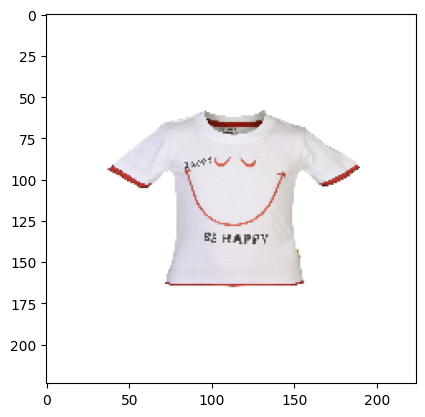

image loaded successfully!


In [6]:
original = load_img(files[4], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [7]:
numpy_image = img_to_array(original)

image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

image batch size (1, 224, 224, 3)


In [8]:
processed_image = preprocess_input(image_batch.copy())
img_features = feat_extractor.predict(processed_image)

print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 1s 752ms/step
number of image features: 4096


array([[0.      , 0.      , 0.      , ..., 0.      , 2.294174, 0.      ]],
      dtype=float32)

In [9]:
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)

In [10]:
images = np.vstack(importedImages)
processed_imgs = preprocess_input(images.copy())
imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
print("number of image features:",imgs_features.size)
imgs_features.shape

24/24 [==============================] - 150s 6s/step
features successfully extracted!
number of image features: 3108864


(759, 4096)

In [11]:
cosSimilarities = cosine_similarity(imgs_features)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)

In [12]:
def retrieve_most_similar_products(given_img):
    print("original product:")
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("most similar products:")
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

original product:


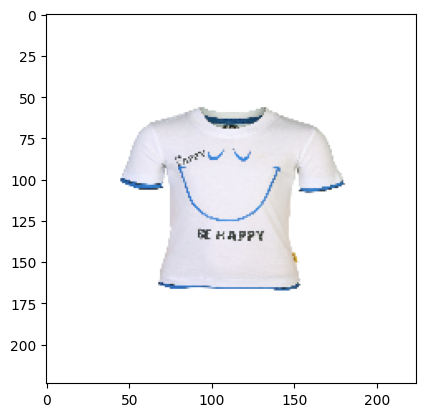

most similar products:


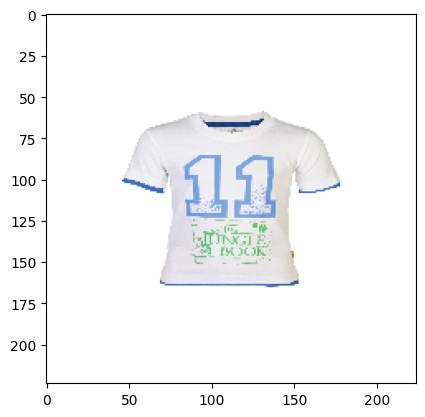

similarity score :  0.89567703


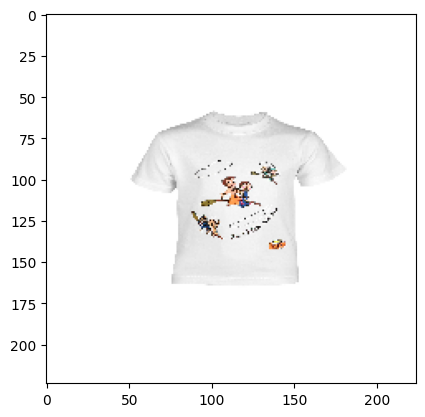

similarity score :  0.86114293


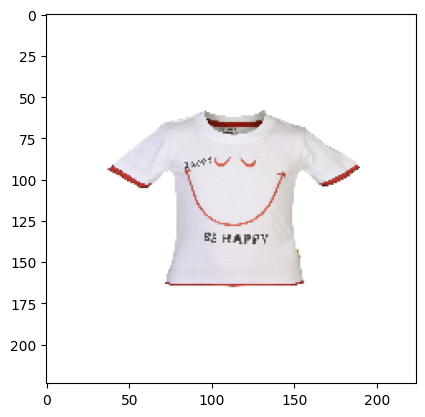

similarity score :  0.8491283


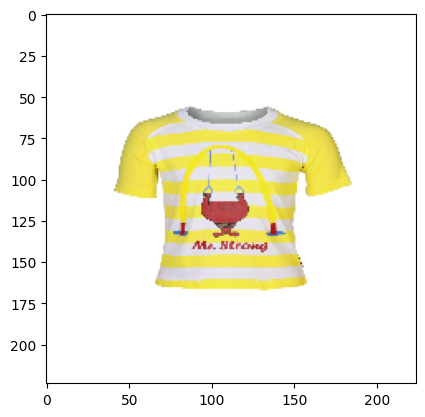

similarity score :  0.8267071


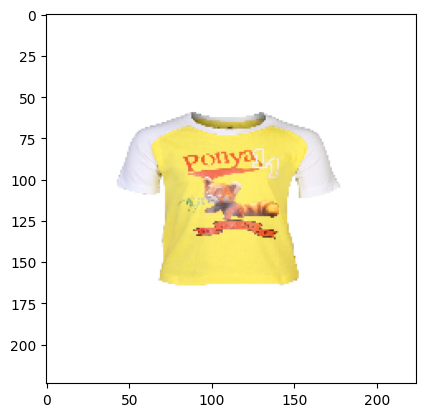

similarity score :  0.82649493


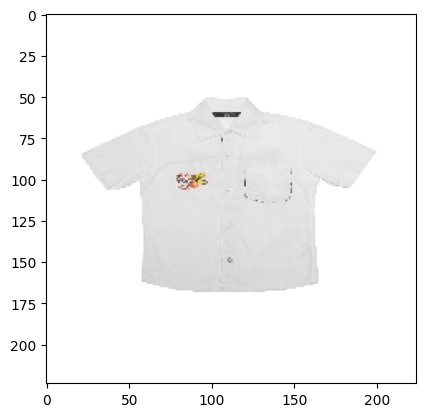

similarity score :  0.8164634


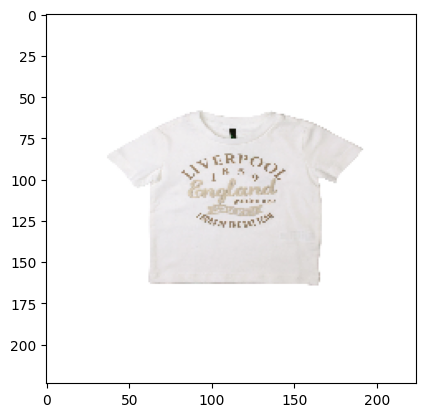

similarity score :  0.8011307


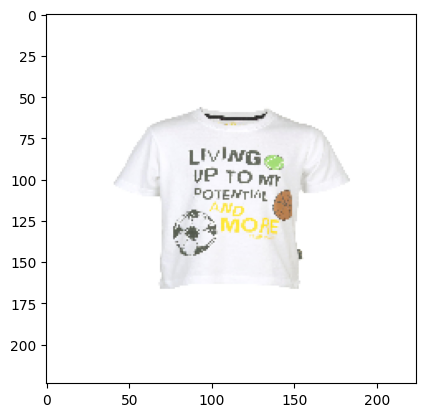

similarity score :  0.8006496


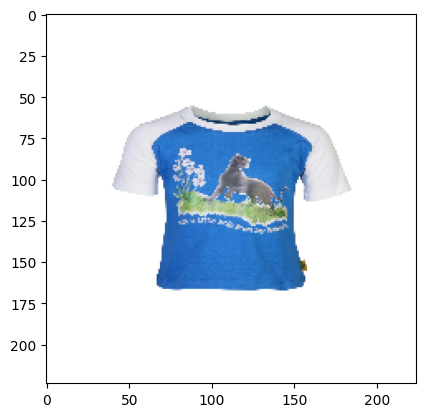

similarity score :  0.7988061


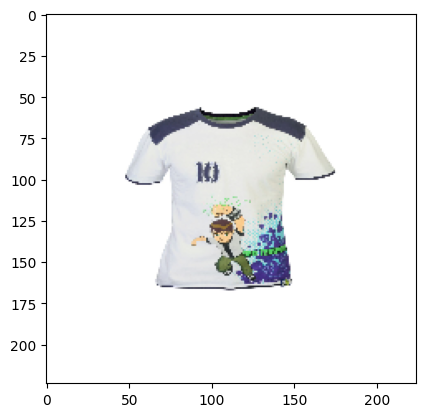

similarity score :  0.7943361


In [14]:
retrieve_most_similar_products(files[45])

original product:


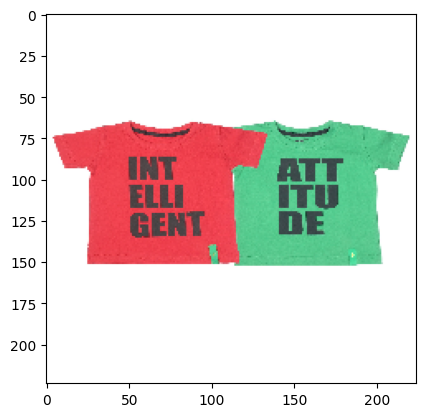

most similar products:


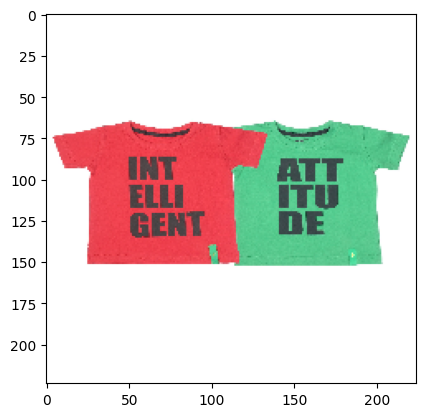

similarity score :  1.0000002


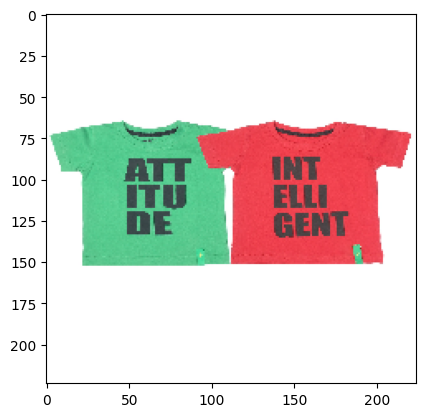

similarity score :  0.9780498


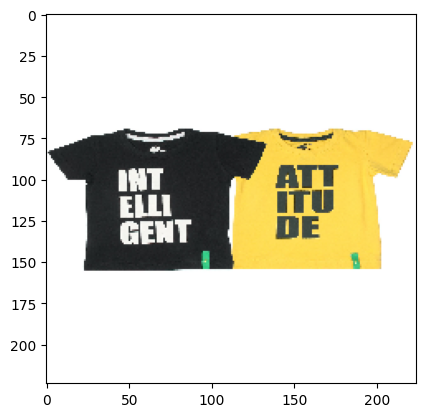

similarity score :  0.84989893


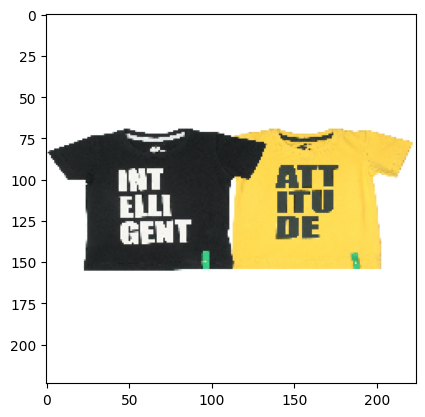

similarity score :  0.8388105


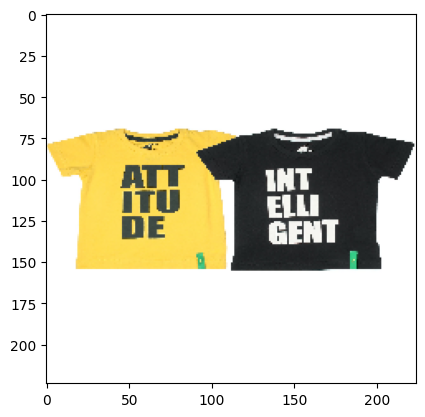

similarity score :  0.7984794


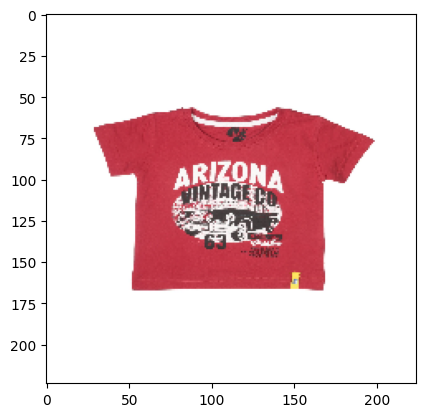

similarity score :  0.69040066


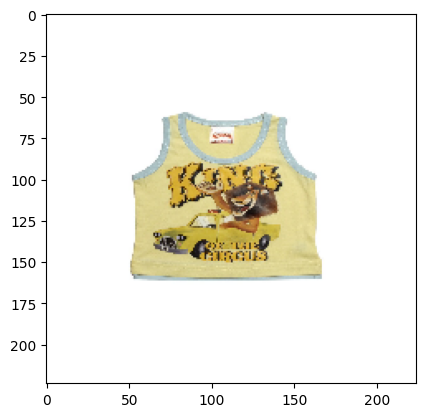

similarity score :  0.68780136


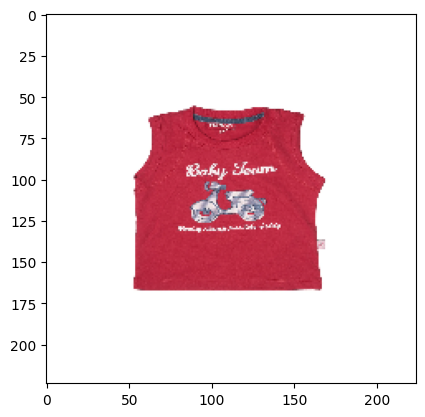

similarity score :  0.68766993


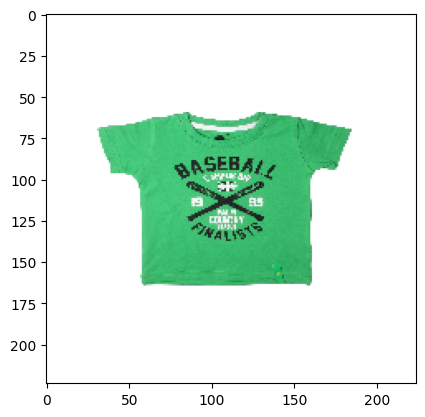

similarity score :  0.6861256


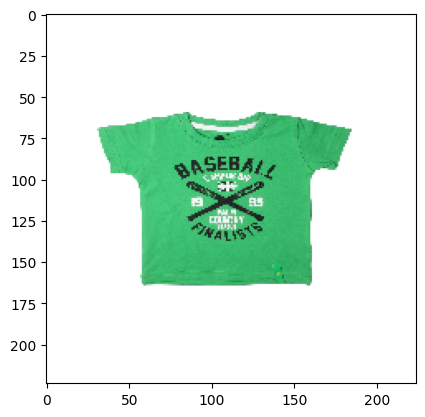

similarity score :  0.6861256


In [15]:
retrieve_most_similar_products (files[90])

In [26]:
class ImageSimilarity:
    def __init__(self, imgs_path, nb_closest_images=10):
        self.imgs_path = imgs_path
        self.nb_closest_images = nb_closest_images
        self.imgs_model_width, self.imgs_model_height = 224, 224

        self.vgg_model = vgg16.VGG16(weights='imagenet')
        self.feat_extractor = Model(inputs=self.vgg_model.input,
                                    outputs=self.vgg_model.get_layer("fc2").output)

        self.files = [imgs_path + "/" + x for x in os.listdir(imgs_path) if "jpg" in x]
        self.imported_images = self.load_images()
        self.imgs_features = self.extract_features()
        self.cos_similarities_df = self.calculate_cosine_similarity()
    
    def load_model(self, path):
        self.feat_extractor = load_model(path)

    def load_images(self):
        imported_images = []
        for f in self.files:
            original = load_img(f, target_size=(self.imgs_model_width, self.imgs_model_height))
            numpy_image = img_to_array(original)
            image_batch = np.expand_dims(numpy_image, axis=0)
            imported_images.append(image_batch)

        return np.vstack(imported_images)

    def extract_features(self):
        processed_imgs = preprocess_input(self.imported_images.copy())
        return self.feat_extractor.predict(processed_imgs)

    def calculate_cosine_similarity(self):
        cos_similarities = cosine_similarity(self.imgs_features)
        return pd.DataFrame(cos_similarities, columns=self.files, index=self.files)

    def retrieve_most_similar_products(self, given_img):
        print("Original product:")
        original = load_img(given_img, target_size=(self.imgs_model_width, self.imgs_model_height))
        plt.imshow(original)
        plt.show()

        print("Most similar products:")
        closest_imgs = self.cos_similarities_df[given_img].sort_values(ascending=False)[1:self.nb_closest_images+1].index
        closest_imgs_scores = self.cos_similarities_df[given_img].sort_values(ascending=False)[1:self.nb_closest_images+1]

        for i in range(len(closest_imgs)):
            original = load_img(closest_imgs[i], target_size=(self.imgs_model_width, self.imgs_model_height))
            plt.imshow(original)
            plt.show()
            print("Similarity score: ", closest_imgs_scores[i])
    def save_model(self, path):
        self.feat_extractor.save(path)

In [27]:
def save_model(self, path):
    self.feat_extractor.save(path)


In [20]:
imgs_path = "/Users/rohittiwari/Desktop/vgg_image-net/data/Apparel/Boys/Images/images_with_product_ids"
image_similarity = ImageSimilarity(imgs_path)
model_path = "saved_model_boys"
image_similarity.save_model(model_path)


24/24 [==============================] - 400s 17s/step
INFO:tensorflow:Assets written to: saved_model_boys/assets


INFO:tensorflow:Assets written to: saved_model_boys/assets


In [14]:
from tensorflow.keras.models import load_model

feat_extractor = load_model("/Users/rohittiwari/Desktop/vgg_image-net/inference_models/Footwear_Boys_feat_extractor.h5")


26/26 [==============================] - 189s 7s/step
Original product:


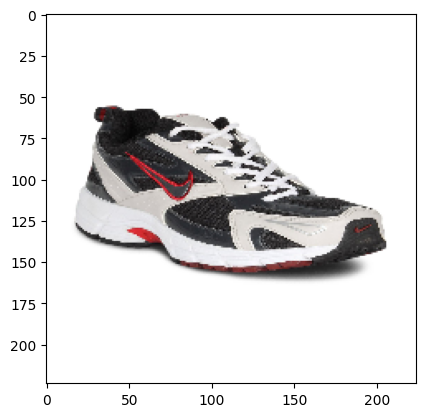

Most similar products:


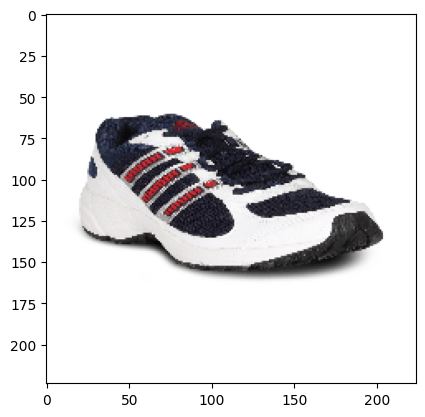

Similarity score:  0.8780061


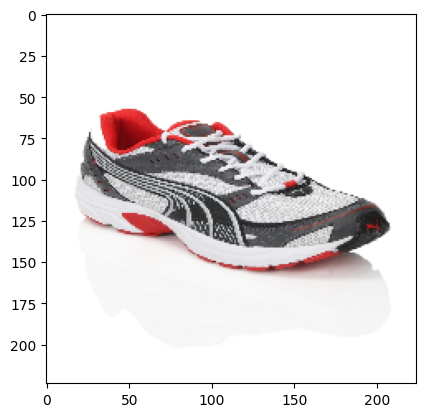

Similarity score:  0.87365466


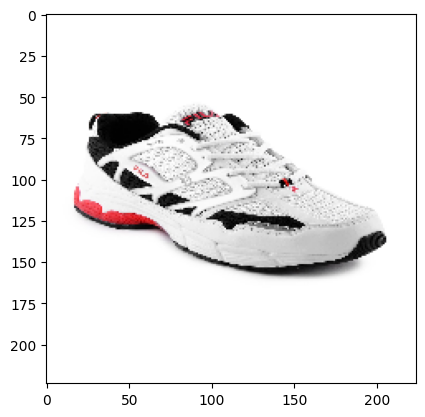

Similarity score:  0.8666076


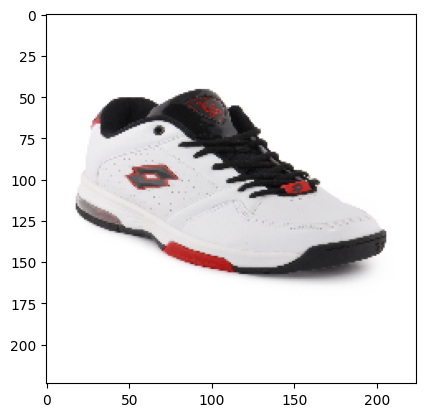

Similarity score:  0.860367


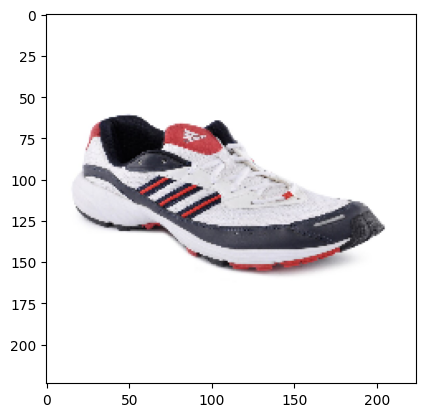

Similarity score:  0.85575056


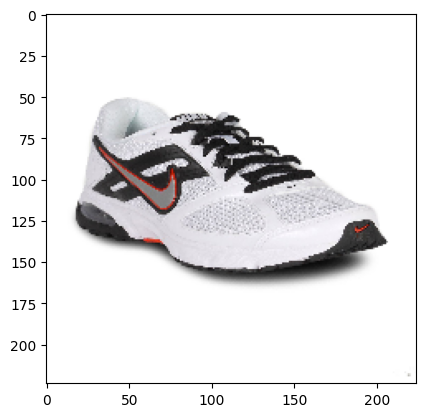

Similarity score:  0.84990615


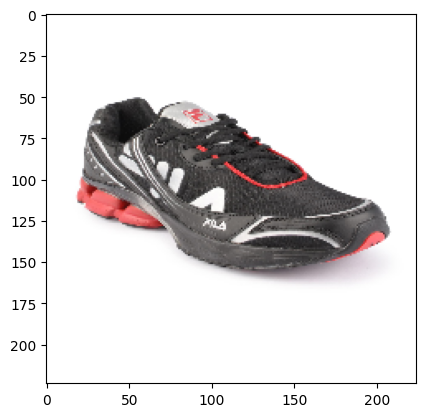

Similarity score:  0.8438837


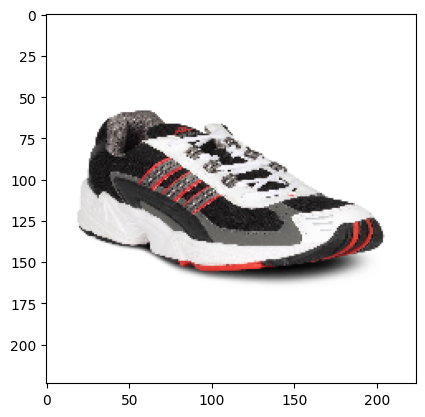

Similarity score:  0.8422218


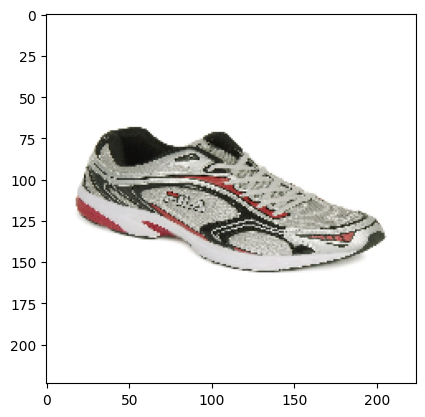

Similarity score:  0.84079325


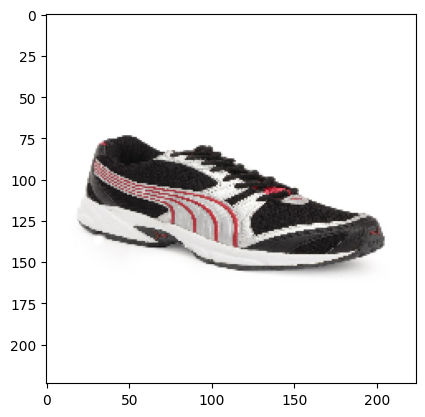

Similarity score:  0.83902794


In [19]:
from image_similarity import ImageSimilarity


image_similarity = ImageSimilarity("/Users/rohittiwari/Desktop/vgg_image-net/data/Footwear/Men")
# model_path = "saved_model_boys"
feat_extractor

given_img = "/Users/rohittiwari/Desktop/vgg_image-net/data/Footwear/Men/1831.jpg"
nb_closest_images = 10
image_similarity.retrieve_most_similar_products(given_img)


In [ ]:
feat_extractor

given_img = "/Users/rohittiwari/Desktop/vgg_image-net/data/Footwear/Men/1637.jpg"
nb_closest_images = 10
image_similarity.retrieve_most_similar_products(given_img)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from keras.applications import vgg16
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input

class ImageSimilarity:
    def __init__(self, imgs_path_dict, nb_closest_images=10):
        self.nb_closest_images = nb_closest_images
        self.imgs_model_width, self.imgs_model_height = 224, 224

        self.vgg_model = vgg16.VGG16(weights='imagenet')

        self.sub_categories = {}
        for category, sub_categories in imgs_path_dict.items():
            for sub_category, path in sub_categories.items():
                feat_extractor = Model(inputs=self.vgg_model.input, outputs=self.vgg_model.get_layer("fc2").output)
                files = [path + "/" + x for x in os.listdir(path) if "jpg" in x]
                imported_images = self.load_images(files)
                imgs_features = self.extract_features(feat_extractor, imported_images)
                cos_similarities_df = self.calculate_cosine_similarity(files, imgs_features)

                self.sub_categories[f"{category}_{sub_category}"] = {
                    "path": path,
                    "feat_extractor": feat_extractor,
                    "files": files,
                    "imported_images": imported_images,
                    "imgs_features": imgs_features,
                    "cos_similarities_df": cos_similarities_df
                }

    def load_images(self, files):
        imported_images = []
        for f in files:
            original = load_img(f, target_size=(self.imgs_model_width, self.imgs_model_height))
            numpy_image = img_to_array(original)
            image_batch = np.expand_dims(numpy_image, axis=0)
            imported_images.append(image_batch)

        return np.vstack(imported_images)

    def extract_features(self, feat_extractor, imported_images):
        processed_imgs = preprocess_input(imported_images.copy())
        return feat_extractor.predict(processed_imgs)

    def calculate_cosine_similarity(self, files, imgs_features):
        cos_similarities = cosine_similarity(imgs_features)
        return pd.DataFrame(cos_similarities, columns=files, index=files)

    def save_models(self, save_dir):
        os.makedirs(save_dir, exist_ok=True)
        for sub_category, data in self.sub_categories.items():
            with open(f"{save_dir}/{sub_category}_feat_extractor.pkl", 'wb') as f:
                pickle.dump(data["feat_extractor"], f)


    def load_models(self, save_dir):
        for sub_category, data in self.sub_categories.items():
            with open(f"{save_dir}/{sub_category}_feat_extractor.pkl", 'rb') as f:
                data["feat_extractor"] = pickle.load(f)

    def load_feat_extractor(self, path):
        self.feat_extractor = load_model(path)

    def retrieve_most_similar_products(self, given_img, category, sub_category):
        key = f"{category}_{sub_category}"
        if key not in self.sub_categories:
            print(f"Category '{category}' and sub-category '{sub_category}' not found.")
            return

        data = self.sub_categories[key]

        print("Original product:")
        original = load_img(given_img, target_size=(self.imgs_model_width, self.imgs_model_height))
        plt.imshow(original)
        plt.show()

        print("Most similar products:")
        closest_imgs = data["cos_similarities_df"][given_img].sort_values(ascending=False)[1:self.nb_closest_images+1].index
        closest_imgs_scores = data["cos_similarities_df"][given_img].sort_values(ascending=False)[1:self.nb_closest_images+1]

        for i in range(len(closest_imgs)):
            original = load_img(closest_imgs[i], target_size=(self.imgs_model_width, self.imgs_model_height))
            plt.imshow(original)
            plt.show()
            print("Similarity score: ", closest_imgs_scores[i])

imgs_path_dict = {
    "Apparel": {
        "Boys": "/Users/rohittiwari/Desktop/vgg_image-net/data/Apparel/Boys",
        "Girls": "/Users/rohittiwari/Desktop/vgg_image-net/data/Apparel/Girls"
    },
    "Footwear": {
        "Boys": "/Users/rohittiwari/Desktop/vgg_image-net/data/Footwear/Men",
        "Girls": "/Users/rohittiwari/Desktop/vgg_image-net/data/Footwear/Women"
    }
}

image_similarity = ImageSimilarity(imgs_path_dict)
image_similarity.save_models("inference_models_pkl")

25/25 [==============================] - 128s 5s/step


INFO:tensorflow:Assets written to: ram://410584a4-29a8-42b5-805f-fd761b771f0a/assets


INFO:tensorflow:Assets written to: ram://410584a4-29a8-42b5-805f-fd761b771f0a/assets


INFO:tensorflow:Assets written to: ram://fd43dbbb-a51c-49dc-aaec-e59f08fd8e22/assets


INFO:tensorflow:Assets written to: ram://fd43dbbb-a51c-49dc-aaec-e59f08fd8e22/assets


INFO:tensorflow:Assets written to: ram://20b26c35-abfc-4a3e-b24a-68ae9b91ee17/assets


INFO:tensorflow:Assets written to: ram://20b26c35-abfc-4a3e-b24a-68ae9b91ee17/assets


INFO:tensorflow:Assets written to: ram://93a7f533-5f63-48d2-9c35-b67e66804d2e/assets


INFO:tensorflow:Assets written to: ram://93a7f533-5f63-48d2-9c35-b67e66804d2e/assets


Original product:


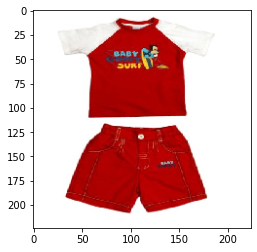

Most similar products:


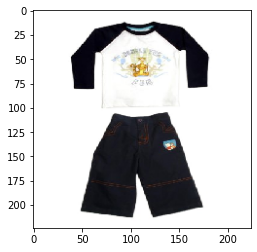

Similarity score:  0.7790096


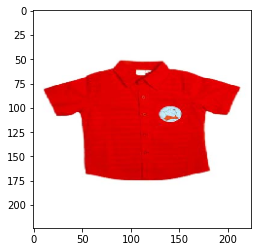

Similarity score:  0.777882


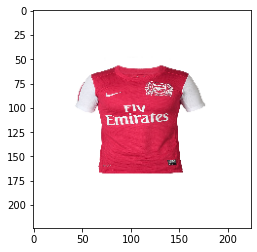

Similarity score:  0.77277637


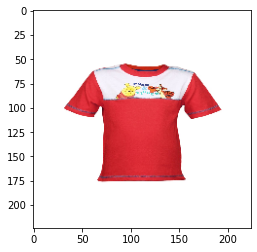

Similarity score:  0.7678683


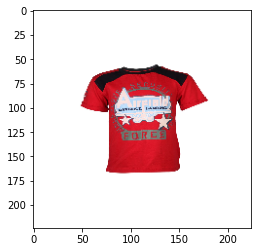

Similarity score:  0.76487595


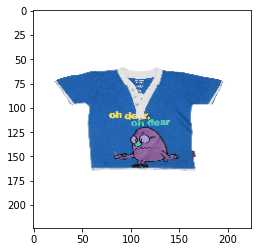

Similarity score:  0.7473329


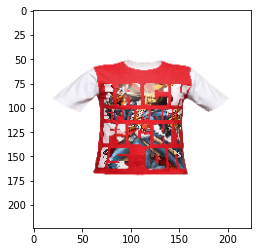

Similarity score:  0.7384131


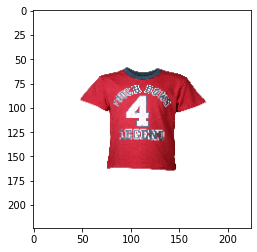

Similarity score:  0.73801064


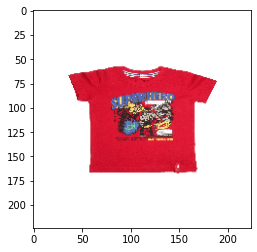

Similarity score:  0.7333281


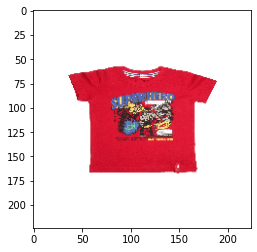

Similarity score:  0.7333281


In [6]:

image_similarity.load_models("/Users/rohittiwari/Desktop/vgg_image-net/inference_models_pkl")
image_similarity.retrieve_most_similar_products("/Users/rohittiwari/Desktop/vgg_image-net/data/Apparel/Boys/2714.jpg", "Apparel", "Boys")


Original product:


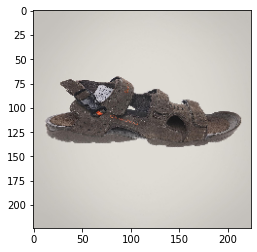

Most similar products:


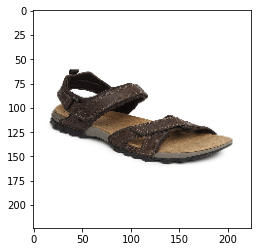

Similarity score:  0.6597229


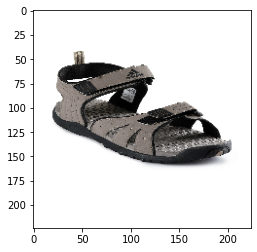

Similarity score:  0.6558574


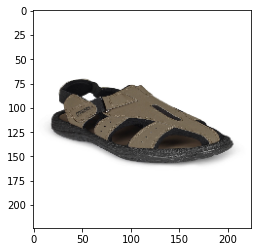

Similarity score:  0.64274853


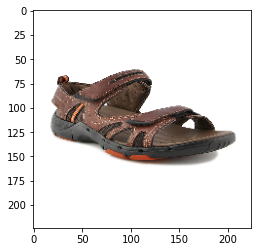

Similarity score:  0.63098955


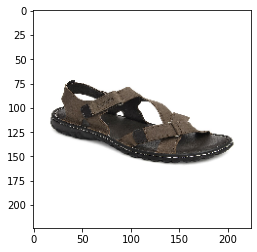

Similarity score:  0.62647325


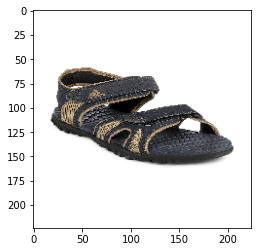

Similarity score:  0.62283665


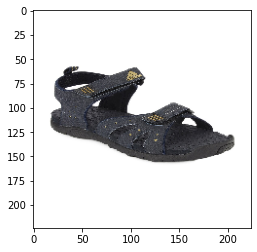

Similarity score:  0.6206503


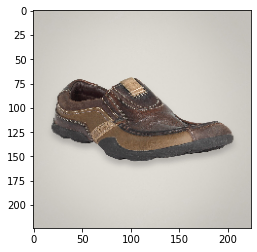

Similarity score:  0.6175531


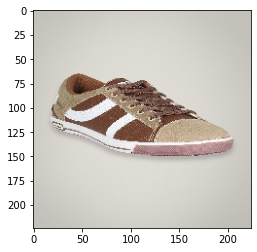

Similarity score:  0.6118124


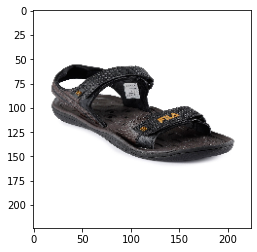

Similarity score:  0.60987526


In [8]:
image_similarity.retrieve_most_similar_products("/Users/rohittiwari/Desktop/vgg_image-net/data/Footwear/Men/1806.jpg", "Footwear", "Boys")
